In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect

import pandas as pd

In [2]:
# Create engine to created local DB
engine = create_engine('postgresql://<pg_user>:<pg_password>@localhost:5432/EmployeeHW')
connection = engine.connect()

In [5]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['titles', 'employees', 'salaries', 'departments', 'dept_mgr']

In [6]:
# Create classes
Titles = Base.classes.titles
Employees = Base.classes.employees
Salaries = Base.classes.salaries

In [7]:
# Create a session
session = Session(engine)

In [8]:
# Query the database making necessary joins
emps = session.query(Employees, Salaries, Titles).filter(Employees.emp_no == Salaries.emp_no).filter(Employees.emp_title_id == Titles.title_id).all()

In [13]:
# Load the results into a pandas dataframe
df = pd.DataFrame(columns=['id', 'salary','title'])

# Takes a while to run and create assembled DF
for record in emps:
    (id, salary, title) = record
    adds = pd.DataFrame([[id.emp_no, salary.salary ,title.title]], columns=['id', 'salary', 'title'])
    adds.dropna()
    df = df.append(adds,ignore_index=True)
    
df

,id,salary,title
0,57444,48973,Engineer
1,13616,40000,Senior Engineer
2,240129,43548,Technique Leader
3,427958,63377,Staff
4,35916,40000,Senior Engineer
...,...,...,...
300019,222402,40000,Staff
300020,70921,40000,Technique Leader
300021,275129,59703,Senior Engineer
300022,202478,48038,Senior Engineer


In [191]:
# End session
session.close()

In [122]:
# Group by Employee title for calculating average salary
bytitle = df
bytitle = bytitle.dropna()
# Type cast salary column as numeric
bytitle = bytitle.astype({'salary': 'int64'})
bytitle = bytitle.groupby('title')

avg_salary = round(bytitle['salary'].mean(),2)

summary_df = pd.DataFrame({"Avg Salary": avg_salary})
summary_df

,Avg Salary
title,
Assistant Engineer,48564.43
Engineer,48535.34
Manager,51531.04
Senior Engineer,48506.80
Senior Staff,58550.17
Staff,58465.38
Technique Leader,48582.90


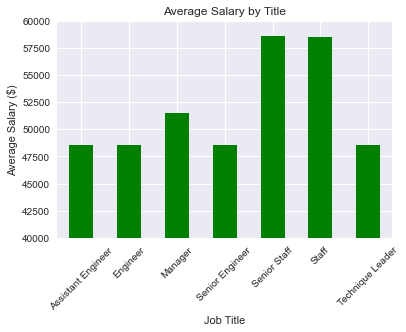

In [128]:
# Create a bar chart of average salary by title using summary dataframe
ylim = [40000,60000]
salary_plot = summary_df.plot(kind="bar",title="Average Salary by Title",ylim = ylim, rot=45,color='green',legend=False)
salary_plot.set_xlabel("Job Title")
salary_plot.set_ylabel("Average Salary ($)")
salary_plot

In [185]:
# Create a plot to visualize the most common salary ranges for employees.

# Bins are (0, 45000),(45001, 60000), (60001, 80000), (80001,200000)).   
salary_bins = [0, 45000, 60000, 80000, 200000]

# Create the names for the four bins
salary_group_names = ["<$45k", "$45k-$60k", "$60k-$80k", "$80k-$200k"]

#Use data frame for the bins and convert salary to numeric
salary_bins_df = df
salary_bins_df = salary_bins_df.astype({'salary': 'int64'})

#Set bins
salary_bins_df['Salary Bins'] = pd.cut(salary_bins_df['salary'], salary_bins, labels=salary_group_names, include_lowest=True)
#Group by new bin column
salary_bins_df = salary_bins_df.groupby(['Salary Bins'])

#Use count function to calculate bin values
bins = salary_bins_df['Salary Bins'].count()
bins

Salary Bins
<$45k         126277
$45k-$60k      90112
$60k-$80k      66219
$80k-$200k     17416
Name: Salary Bins, dtype: int64

Text(0, 0.5, '')

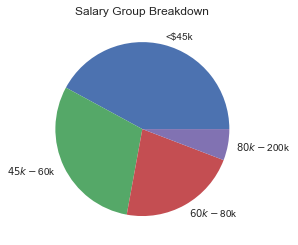

In [190]:
# Use series to plot
bin_plot = bins.plot(kind="pie", title="Salary Group Breakdown")
bin_plot.set_ylabel("")

In [13]:
# Epilogue, query Employee ID 499942
me = session.query(Employees).filter(Employees.emp_no == 499942)

for record in me:
    (id) = record
    print(f"My ID#: {id.emp_no} My Name: {id.first_name} {id.last_name}")

My ID#: 499942 My Name: April Foolsday
